<a href="https://colab.research.google.com/github/fhun/bus-arrival-time-neural-network-ga-kalman/blob/master/2_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import numpy as np

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import * #retrieving information on running processes and system utilization (CPU, memory, disks, network, sensors)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1096384324746844924, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13564136572673732469
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Import data

Route 101 ***U Wandsbek Markt to S Rübenkamp***

In [ ]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed.csv"
df_proceeded = pd.read_csv(path)

In [ ]:
df_proceeded

,Unnamed: 0,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday
0,0,2019-01-02 09:47:00,U Wandsbek Markt|Wandsbeker Allee,0.0,180.0,204.0,2,1,1
1,1,2019-01-02 09:50:00,Wandsbeker Allee|U Straßburger Straße,0.0,120.0,108.0,2,1,1
2,2,2019-01-02 09:52:00,U Straßburger Straße|U Alter Teichweg,0.0,120.0,96.0,2,1,1
3,3,2019-01-02 09:54:00,U Alter Teichweg|Habichtstraße (Mitte),0.0,180.0,168.0,2,1,1
4,4,2019-01-02 09:57:00,Habichtstraße (Mitte)|U Habichtstraße,0.0,60.0,54.0,2,1,1
...,...,...,...,...,...,...,...,...,...
133269,133269,2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1.0,180.0,144.0,0,12,1
133270,133270,2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1.0,60.0,66.0,0,12,1
133271,133271,2019-12-23 09:02:00,Hartzloh|AK Barmbek,1.0,60.0,60.0,0,12,1
133272,133272,2019-12-23 09:03:00,AK Barmbek|Hebebrandstraße,1.0,120.0,132.0,0,12,1


In [ ]:
#df_proceeded = df_proceeded.sort_values(by=['Time'])

Route 102 ***S Rübenkamp to U Wandsbek Markt***

In [ ]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed102.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed102.csv"
df_proceeded102 = pd.read_csv(path)
#df_proceeded102 = df_proceeded102.sort_values(by=['Time'])

Route 201 ***U Wandsbek Markt to Lufthansa-Basis (Haupteingang)***

In [ ]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed201.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed201.csv"
df_proceeded201 = pd.read_csv(path)
#df_proceeded201 = df_proceeded201.sort_values(by=['Time'])

Route 202 ***Lufthansa-Basis (Haupteingang) to U Wandsbek Markt***

In [ ]:
#path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_0420_data_processed202.csv"
path = "/content/drive/My Drive/Colab Notebooks/Thesis/ist_01_12_19_data_processed202.csv"
df_proceeded202 = pd.read_csv(path)
#df_proceeded202 = df_proceeded202.sort_values(by=['Time'])

## **Preprocessing**

Route 101 ***U Wandsbek Markt to S Rübenkamp***

In [ ]:
data = df_proceeded[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data

,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,
2019-01-02 09:47:00,U Wandsbek Markt|Wandsbeker Allee,0,2,1,204.0
2019-01-02 09:50:00,Wandsbeker Allee|U Straßburger Straße,0,2,1,108.0
2019-01-02 09:52:00,U Straßburger Straße|U Alter Teichweg,0,2,1,96.0
2019-01-02 09:54:00,U Alter Teichweg|Habichtstraße (Mitte),0,2,1,168.0
2019-01-02 09:57:00,Habichtstraße (Mitte)|U Habichtstraße,0,2,1,54.0
...,...,...,...,...,...
2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1,0,1,144.0
2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1,0,1,66.0
2019-12-23 09:02:00,Hartzloh|AK Barmbek,1,0,1,60.0


In [ ]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
data.dtypes

Node A to Node B    category
Precipitation       category
dayofweek           category
timeofday           category
Driving_time_s       float64
dtype: object

## One-hot encoding

One-hot encode the categorical feautures.



In [ ]:
data = pd.get_dummies(data, columns=columns_to_category) # One-hot encoding the categories
data.head()

,Driving_time_s,Node A to Node B_AK Barmbek|Hebebrandstraße,Node A to Node B_Habichtsplatz|AK Barmbek,Node A to Node B_Habichtsplatz|Hartzloh,Node A to Node B_Habichtsplatz|Neue Wöhr,Node A to Node B_Habichtstraße (Mitte)|Habichtsplatz,Node A to Node B_Habichtstraße (Mitte)|U Habichtstraße,Node A to Node B_Hartzloh|AK Barmbek,Node A to Node B_Hartzloh|Hebebrandstraße,Node A to Node B_Hebebrandstraße|S Rübenkamp,Node A to Node B_Lämmersieth (Nord)|Habichtstraße (Mitte),Node A to Node B_Neue Wöhr|Hartzloh,Node A to Node B_Neue Wöhr|S Rübenkamp,Node A to Node B_S Rübenkamp|Source,Node A to Node B_U Alter Teichweg|Habichtstraße (Mitte),Node A to Node B_U Alter Teichweg|Lämmersieth (Nord),Node A to Node B_U Alter Teichweg|U Habichtstraße,Node A to Node B_U Habichtstraße|Habichtsplatz,Node A to Node B_U Straßburger Straße|Habichtstraße (Mitte),Node A to Node B_U Straßburger Straße|U Alter Teichweg,Node A to Node B_U Wandsbek Markt|Habichtsplatz,Node A to Node B_U Wandsbek Markt|Habichtstraße (Mitte),Node A to Node B_U Wandsbek Markt|Neue Wöhr,Node A to Node B_U Wandsbek Markt|S Rübenkamp,Node A to Node B_U Wandsbek Markt|U Alter Teichweg,Node A to Node B_U Wandsbek Markt|U Habichtstraße,Node A to Node B_U Wandsbek Markt|U Straßburger Straße,Node A to Node B_U Wandsbek Markt|Wandsbeker Allee,Node A to Node B_Wandsbeker Allee|U Alter Teichweg,Node A to Node B_Wandsbeker Allee|U Straßburger Straße,Precipitation_-499,Precipitation_0,Precipitation_1,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,timeofday_0,timeofday_1,timeofday_2,timeofday_3,timeofday_4
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 09:47:00,204.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:50:00,108.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:52:00,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:54:00,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2019-01-02 09:57:00,54.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
data.describe

<bound method NDFrame.describe of                      Driving_time_s  ...  timeofday_4
Time                                 ...             
2019-01-02 09:47:00           204.0  ...            0
2019-01-02 09:50:00           108.0  ...            0
2019-01-02 09:52:00            96.0  ...            0
2019-01-02 09:54:00           168.0  ...            0
2019-01-02 09:57:00            54.0  ...            0
...                             ...  ...          ...
2019-12-23 08:58:00           144.0  ...            0
2019-12-23 09:01:00            66.0  ...            0
2019-12-23 09:02:00            60.0  ...            0
2019-12-23 09:03:00           132.0  ...            0
2019-12-23 09:05:00            60.0  ...            0

[133274 rows x 45 columns]>

In [ ]:
data101 = data.copy()
data101

## Preprocessing with other routes (journeys)

Journey 102 ***S Rübenkamp to U Wandsbek Markt***

In [ ]:
data = df_proceeded102[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded102['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [ ]:
data = data.loc[data['Node A to Node B'].isin(['U Straßburger Straße|Wandsbeker Allee',
'AK Barmbek|Hartzloh',
'U Habichtstraße|Habichtstraße (Mitte)',
'Habichtsplatz|U Habichtstraße',
'U Alter Teichweg|U Straßburger Straße',
'Wandsbeker Allee|U Wandsbek Markt',
'Hartzloh|Habichtsplatz',
'S Rübenkamp|AK Barmbek',
'Habichtstraße (Mitte)|U Alter Teichweg'])]
df_proceeded102 = data

In [ ]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [ ]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data[:50]

In [ ]:
data102 = data.copy()
data102

Route 201 ***U Wandsbek Markt to Lufthansa-Basis (Haupteingang)***

In [ ]:
data = df_proceeded201[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded201['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [ ]:
data = data.loc[data['Node A to Node B'].isin(['Kapstadtring|Manilabrücke',
'U Alsterdorf|Hindenburgstraße',
'Habichtstraße (Mitte)|U Habichtstraße',
'Neue Wöhr|Hartzloh',
'Hartzloh|AK Barmbek',
'Brabandstraße|Moltrechtweg',
'Alsterkrugchaussee (Mitte)|Obenhauptstraße',
'Manilabrücke|Sydneystraße',
'Hebebrandstraße|S Rübenkamp',
'U Habichtstraße|Habichtsplatz',
'Moltrechtweg|Alsterkrugchaussee (Mitte)',
'Hindenburgstraße|Brabandstraße',
'S Rübenkamp|Kapstadtring',
'Wandsbeker Allee|U Straßburger Straße',
'Sydneystraße|U Alsterdorf',
'Habichtsplatz|Neue Wöhr',
'AK Barmbek|Hebebrandstraße',
'U Straßburger Straße|U Alter Teichweg',
'Obenhauptstraße|Lufthansa-Basis (Haupteingang)',
'U Alter Teichweg|Habichtstraße (Mitte)',
'U Wandsbek Markt|Wandsbeker Allee',
])]
df_proceeded201 = data

In [ ]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [ ]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data[:50]

In [ ]:
data201 = data.copy()
data201

Route 202 ***Lufthansa-Basis (Haupteingang) to U Wandsbek Markt***

In [ ]:
data = df_proceeded202[['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday', 'Driving_time_s']]
data.index = df_proceeded202['Time']
data['Precipitation'] = data['Precipitation'].astype('int')
data['timeofday'] = data['timeofday'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data.loc[data.Precipitation == -499 ]=0
data.loc[data.Precipitation == -499 ]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Node A to Node B,Precipitation,dayofweek,timeofday,Driving_time_s
Time,,,,,


In [ ]:
data = data.loc[data['Node A to Node B'].isin(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
        'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
        'Alsterkrugchaussee (Mitte)|Moltrechtweg',
        'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
        'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
        'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
        'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
        'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
        'U Habichtstraße|Habichtstraße (Mitte)',
        'Habichtstraße (Mitte)|U Alter Teichweg',
        'U Alter Teichweg|U Straßburger Straße',
        'U Straßburger Straße|Wandsbeker Allee',
        'Wandsbeker Allee|U Wandsbek Markt'])]
df_proceeded202 = data

In [ ]:
columns_to_category = ['Node A to Node B', 'Precipitation', 'dayofweek', 'timeofday']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

In [ ]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data[:50]

In [ ]:
data202 = data.copy()
data202

# Select route to implement

In [ ]:
#select the route one by one
route = 202
month = 4

if route == 101:
  #route 101
  data = data101.copy()
  path_end = "data101"
  path_name = "Route 101 U Wandsbek Markt to S Rübenkamp"
  bs = 2**4
  bs_name = str(bs)
  n_layers = 3

elif route ==102:
  #route 102
  data = data102.copy()
  path_end = "data102"
  path_name = "Route 102 S Rübenkamp to U Wandsbek Markt"
  bs = 2**7
  bs_name = str(bs)
  n_layers = 2

elif route == 201:
  #route 201
  data = data201.copy()
  path_end = "data201"
  path_name = "Route 201 U Wandsbek Markt to Lufthansa-Basis (Haupteingang)"
  bs = 2**6
  bs_name = str(bs)
  n_layers = 2

elif route == 202:
#route 202
  data = data202.copy()
  path_end = "data202"
  path_name = "Route 202 Lufthansa-Basis (Haupteingang) to U Wandsbek Markt"
  bs = 2**6
  bs_name = str(bs)
  n_layers = 3



In [ ]:
data = data.loc[pd.to_datetime(data.index).month == month]

In [ ]:
#Import data to collect results and compare
#comb_result = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+".csv")
#comb_result_rmse = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+".csv")
comb_result = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+"_m"+str(month)+".csv")
#comb_result_rmse = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+"_m"+str(month)+".csv")

In [ ]:
size_trip = len(comb_result['Path'].unique())
#size_trip = 1

# Select model

In [ ]:
# set variable for RNN structure
look_back = size_trip*1 #1*24 # D -> 1, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1


# Data Preprocessing to RNN format

"The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features]."

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [ ]:
def df_to_rnn_scaling(df, look_back=5, target_column='target', scale_X=True): #, test_size=0.5
    df = df.copy()

    # move traget function to last column of the dataframe
    df['target'] = df[target_column] # Make a copy of the target column to the last column
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target

    
    #Split with day of the month
    s =pd.to_datetime(data.index).day.tolist()

    split_index_val = s.index(15) #validation set is cover on 3th week
    split_index_test = s.index(23) #test set covers last week
    #split_index = int(df.shape[0]*test_size) # the index at which to split df into train and test
    
    train = df[:split_index_val]
    val = df[split_index_val:split_index_test]
    test = df[split_index_test:]
   
    # features scaling
    scaler = MinMaxScaler()
    # fit scaler
    scaler.fit(train)
    # transform training dataset
    train = scaler.transform(train)
    # transform validation dataset
    val = scaler.transform(val)
    # transform test dataset
    test = scaler.transform(test)

    # ...train
    X_train = train[:, :target_location]
    y_train = train[:, target_location]

    # ...validation
    X_val = val[:, :target_location]
    y_val = val[:, target_location]

    # ...test
    X_test = test[:, :target_location]
    y_test = test[:, target_location] 
        
    # Reshape the arrays
    num_features = target_location # All columns before the target column are features

    # train
    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, num_features)) # Initialize the required dataframe with an zeros array.
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    # validation
    samples_val = X_val.shape[0] - look_back
    X_val_reshaped = np.zeros((samples_val, look_back, num_features))
    y_val_reshaped = np.zeros((samples_val))

    for i in range(samples_val):
        y_position = i + look_back
        X_val_reshaped[i] = X_val[i:y_position]
        y_val_reshaped[i] = y_val[y_position]

    # test
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_val_reshaped, y_val_reshaped, X_test_reshaped, y_test_reshaped, split_index_test, scaler

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, split_index_test, scaler = df_to_rnn_scaling(df=data, look_back=look_back, target_column='Driving_time_s', scale_X=True)

In [ ]:
print('X_train_shape: ', X_train.shape,' ', 'X_test_shape: ', X_test.shape)
print('y_train_shape: ', y_train.shape,' ', 'y_test_shape: ', y_test.shape)

X_train_shape:  (9046, 19, 32)   X_test_shape:  (1422, 19, 32)
y_train_shape:  (9046,)   y_test_shape:  (1422,)


In [ ]:
X_train[:1]

array([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 

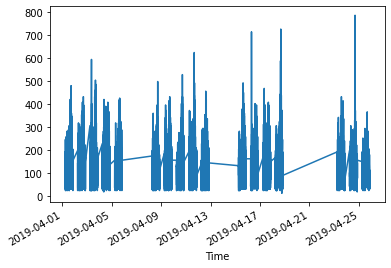

In [ ]:
date_time = pd.to_datetime(data.index)
#plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = data['Driving_time_s']
plot_features.index = date_time
_ = plot_features.plot()


# LSTM model

In [ ]:
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: pyyaml, h5py, scipy, numpy
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [ ]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
keras.backend.clear_session()
from keras.optimizers import Adam, SGD, Nadam
!pip install livelossplot
from livelossplot import PlotLossesKeras
#from keras.experimental import CosineDecayRestarts

In [ ]:
# to make output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

checkpoint1 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/LSTM.best_mse_"+path_end+bs_name+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/LSTM.best_rmse_"+path_end+bs_name+".hdf5", monitor='val_root_mean_squared_error', verbose=1, save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Thesis/best model/LSTM.best_mae_"+path_end+bs_name+".hdf5", monitor='val_mae', verbose=1, save_best_only=True, mode='min')


LSTM model



In [ ]:
#crate model
model = keras.models.Sequential() 
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (look_back, num_features)))
#Hidden Layer 1
model.add(keras.layers.LSTM(16, name = 'lstm_1', return_sequences=True, kernel_initializer='TruncatedNormal'))#, activation='relu'))
model.add(LeakyReLU())
model.add(keras.layers.Dropout(0.2, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

# Adds remaining hidden layers
for i in range(2, n_layers + 1):
    if i == n_layers: #the last hidden layer
        model.add(keras.layers.LSTM(16, name = 'lstm_{}'.format(i), return_sequences=False, kernel_initializer='TruncatedNormal', use_bias=False, activation='relu'))
        model.add(keras.layers.Dropout(0.2, name = 'dropout_{}'.format(i)))
        model.add(BatchNormalization(name = 'batch_norm_{}'.format(i)))
    else:
        model.add(keras.layers.LSTM(16, name = 'lstm_{}'.format(i), return_sequences=True, kernel_initializer='TruncatedNormal', use_bias=False)) #16*(2**i)
                        #name='h{}'.format(i)))#, activation='relu'))
        model.add(LeakyReLU())
        model.add(keras.layers.Dropout(0.2, name = 'dropout_{}'.format(i)))
        model.add(BatchNormalization(name = 'batch_norm_{}'.format(i)))

#Layer output
model.add(keras.layers.Dense(1))



'''
lr = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=0.0005, first_decay_steps=300, t_mul=2.0, m_mul=1.0, alpha=0.0,
    name=None
)
'''
lr=1.e-3
'''
n_steps=2000
global_step=1
LR = keras.experimental.CosineDecayRestarts(
    initial_learning_rate=lr,
    first_decay_steps=n_steps,
    t_mul= 1.5,
    m_mul= 1,
    alpha=0.1,
    name=None
)
'''
adam = Adam(learning_rate=lr) #, weight_decay=1e-5)

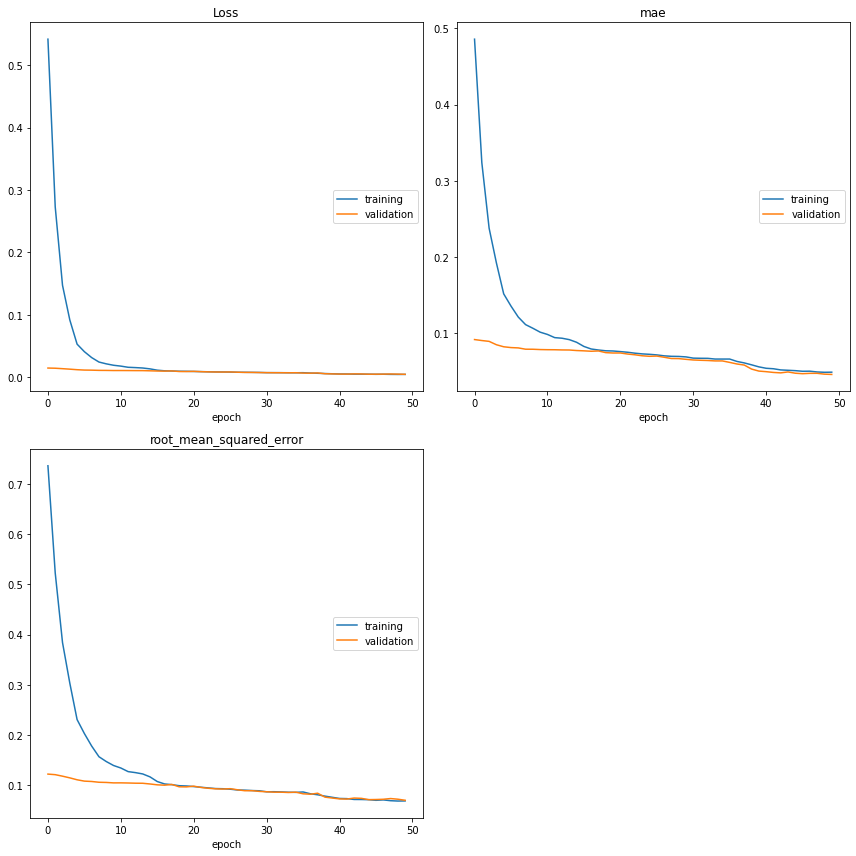

Loss
	training         	 (min:    0.005, max:    0.542, cur:    0.005)
	validation       	 (min:    0.005, max:    0.015, cur:    0.005)
mae
	training         	 (min:    0.049, max:    0.486, cur:    0.049)
	validation       	 (min:    0.046, max:    0.092, cur:    0.046)
root_mean_squared_error
	training         	 (min:    0.068, max:    0.736, cur:    0.069)
	validation       	 (min:    0.070, max:    0.122, cur:    0.070)


In [ ]:
model.compile(loss="mean_squared_error", optimizer=adam, metrics=['RootMeanSquaredError', 'mae'])


'''
schedule = SGDRScheduler(min_lr=7.7e-6, #1e-5
                                     max_lr=2.9e-2, # 1e-2
                                     steps_per_epoch=np.ceil(1/2**13),
                                     lr_decay=0.9,
                                     cycle_length=25, # 5
                                     mult_factor=1.5)
'''
history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[callback, checkpoint1, checkpoint2, checkpoint3, PlotLossesKeras()],
                   validation_data=(X_val, y_val))
#mse_test = model.evaluate(X_test, y_test)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 19, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 32)            8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 19, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 19, 32)            128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 64)            24576     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 19, 64)            0

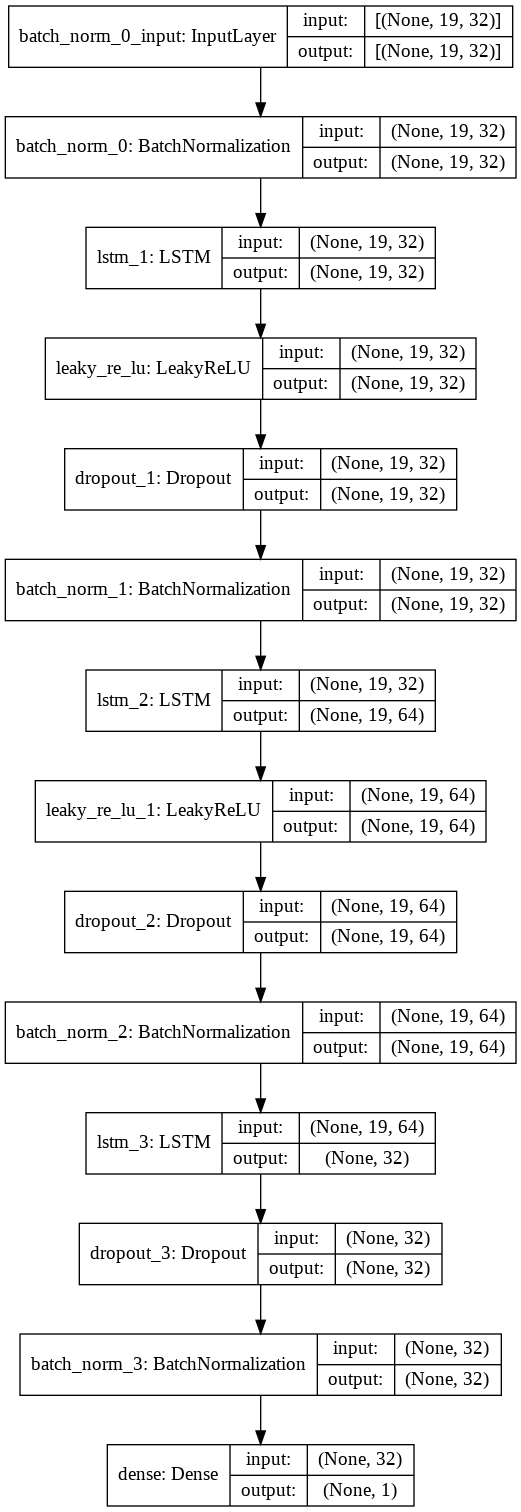

In [ ]:
keras.utils.plot_model(model, "my_hb_model.png", show_shapes=True)

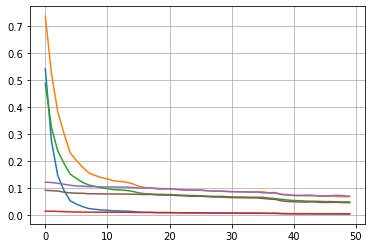

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

# Cross validate on the test set

In [ ]:
%time
from keras.models import load_model

# Load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/best model/LSTM.best_mse_'+path_end+bs_name+'.hdf5') # Gave an error when loading without 'custom_objects'.. fixed by https://github.com/keras-team/keras/issues/3911

# Compile with the same settings as it has been saved with earlier
model.compile(loss="mean_squared_error", optimizer=adam, metrics=['RootMeanSquaredError', 'mae'])

print('FINISHED')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
FINISHED


In [ ]:
#predict from test set
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

In [ ]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 1s 6ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - mae: 0.0449


[0.004672599490731955, 0.06835641711950302, 0.045974887907505035]

In [ ]:
# invert scaling for forecast
inv_X_test = X_test.reshape((X_test.shape[0], look_back*num_features))
inv_y_pred = np.concatenate((inv_X_test[:, -num_features:], y_pred), axis=1)
inv_y_pred = scaler.inverse_transform(inv_y_pred)
inv_y_pred = inv_y_pred[:,-1]

In [ ]:
inv_y_pred

array([178.26169288,  62.64709917,  89.75245437, ..., 169.36238122,
        71.8743255 , 158.60638994])

In [ ]:
# invert scaling for actual
inv_y_true = np.concatenate((inv_X_test[:,-num_features:], y_true), axis=1)
inv_y_true = scaler.inverse_transform(inv_y_true)
inv_y_true = inv_y_true[:,-1]

In [ ]:
# calculate RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(inv_y_true, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y_true, inv_y_pred))
mae = mean_absolute_error(inv_y_true, inv_y_pred)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test MSE: 1715.946
Test RMSE: 41.424
Test MAE: 27.861


In [ ]:
#for plotting graph

x = data[split_index_test:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:]

Show in the graph only first 50 points.

45/45 [==============================] - 0s 6ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - mae: 0.0460
FINISHED


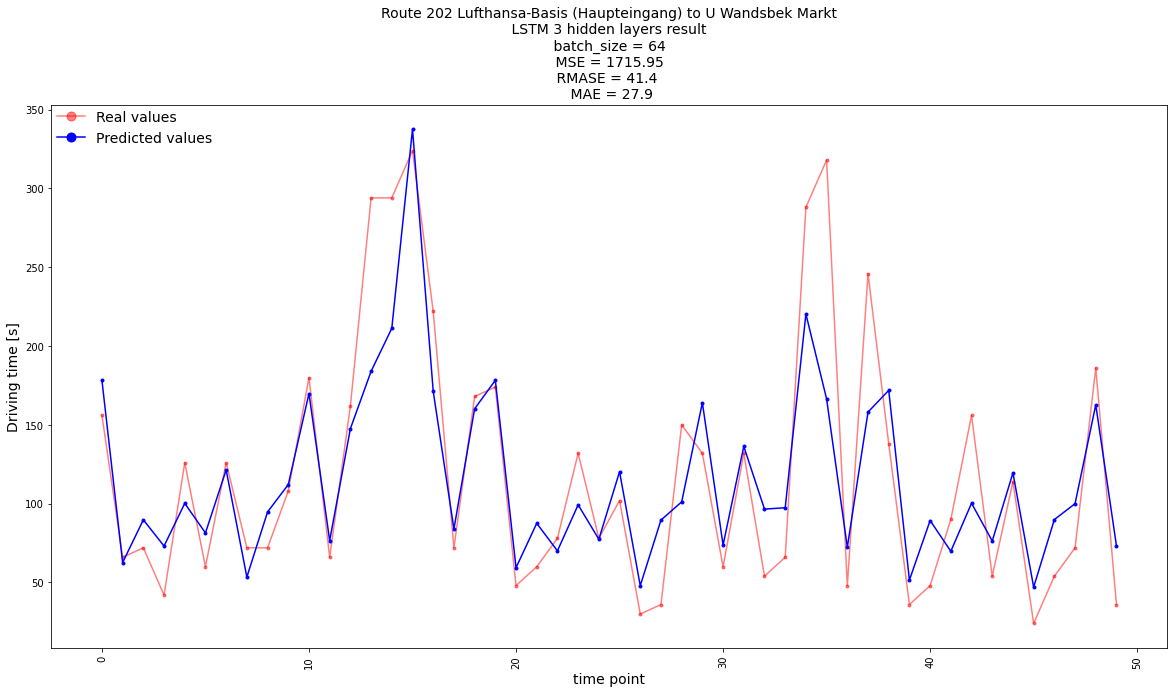

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(inv_y_true[:50], '.-', color='red', label='Real values', alpha=0.5)
plt.plot(inv_y_pred[:50], '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Driving time [s]', fontsize=14)
plt.xlabel('time point', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, rmse_result, mae_result = model.evaluate(X_test, y_test)

plt.title(path_name+'\n LSTM %.0f hidden layers result \n batch_size = %.0f \n MSE = %.2f \n RMASE = %.1f  \n MAE = %.1f' % (n_layers, bs, mse, rmse, mae), fontsize = 14)

print('FINISHED')

45/45 [==============================] - 0s 6ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 - mae: 0.0460
FINISHED


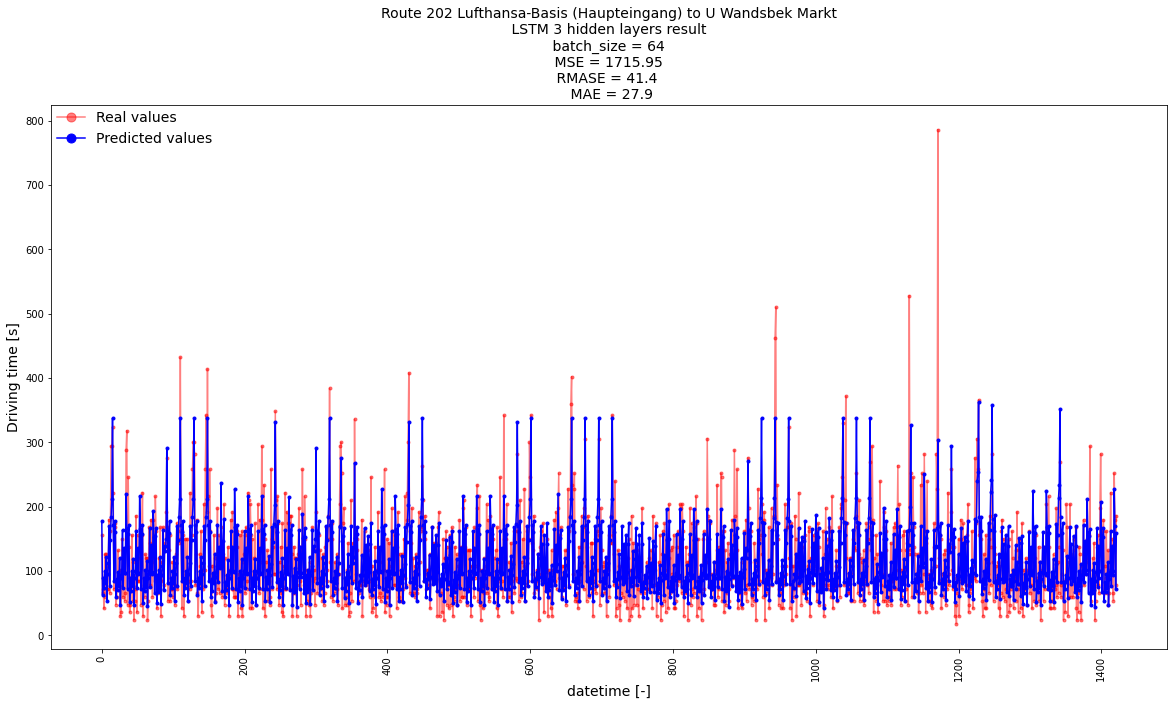

In [ ]:
plt.figure(figsize=(20,10))
plt.plot( inv_y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( inv_y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Driving time [s]', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, rmse_result, mae_result = model.evaluate(X_test, y_test)

plt.title(path_name+'\n LSTM %.0f hidden layers result \n batch_size = %.0f \n MSE = %.2f \n RMASE = %.1f  \n MAE = %.1f' % (n_layers, bs, mse, rmse, mae), fontsize = 14)

print('FINISHED')

# Combine results

In [ ]:
comb_result= comb_result.drop(['Unnamed: 0'], axis=1) #, 'Unnamed: 0.1', 'Unnamed: 0.1.1'

In [ ]:
comb_result

In [ ]:
int(datetime_difference)

19

In [ ]:
comb_result=comb_result[int(datetime_difference):].reset_index(drop=True)
#comb_result = comb_result.drop(['level_0'], axis = 1)
comb_result

In [ ]:
len(inv_y_pred[:])

1422

In [ ]:
comb_result['LSTM_'+str(n_layers)+'H_'+bs_name] = inv_y_pred[:]
comb_result

,Date time,Path,Actual,Actual_trip_cum,MLP,MLP_trip_cum,MLP_Kalman,MLP_Kalman_trip_cum,LSTM_3H_64
0,2019-04-23 16:49:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,156.0,156,121.648451,121,121.648451,121.648451,178.261693
1,2019-04-23 16:51:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),66.0,222,121.315331,242,138.491105,260.139556,62.647099
2,2019-04-23 16:52:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,72.0,294,122.158887,365,109.445701,369.585258,89.752454
3,2019-04-23 16:54:00,Moltrechtweg|Brabandstraße,42.0,336,120.377157,485,101.480843,471.066100,73.118218
4,2019-04-23 16:55:00,Brabandstraße|Hindenburgstraße,126.0,462,121.039073,606,94.025853,565.091953,100.192943
...,...,...,...,...,...,...,...,...,...
1417,2019-04-25 07:41:00,U Habichtstraße|Habichtstraße (Mitte),54.0,1614,125.380412,1876,118.402453,1783.071842,94.599245
1418,2019-04-25 07:43:00,Habichtstraße (Mitte)|U Alter Teichweg,252.0,1866,125.380394,2002,114.813404,1897.885246,227.284139
1419,2019-04-25 07:46:00,U Alter Teichweg|U Straßburger Straße,180.0,2046,124.038584,2126,122.162981,2020.048227,169.362381
1420,2019-04-25 07:48:00,U Straßburger Straße|Wandsbeker Allee,78.0,2124,125.380412,2251,126.822178,2146.870405,71.874325


In [ ]:
if route == 202:
  route_unique = np.array(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
        'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
        'Alsterkrugchaussee (Mitte)|Moltrechtweg',
        'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
        'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
        'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
        'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
        'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
        'U Habichtstraße|Habichtstraße (Mitte)',
        'Habichtstraße (Mitte)|U Alter Teichweg',
        'U Alter Teichweg|U Straßburger Straße',
        'U Straßburger Straße|Wandsbeker Allee',
        'Wandsbeker Allee|U Wandsbek Markt'], dtype= object)
else:
  route_unique = (comb_result.Path.unique())
route_unique

array(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
       'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
       'Alsterkrugchaussee (Mitte)|Moltrechtweg',
       'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
       'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
       'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
       'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek',
       'AK Barmbek|Hartzloh', 'Hartzloh|Habichtsplatz',
       'Habichtsplatz|U Habichtstraße',
       'U Habichtstraße|Habichtstraße (Mitte)',
       'Habichtstraße (Mitte)|U Alter Teichweg',
       'U Alter Teichweg|U Straßburger Straße',
       'U Straßburger Straße|Wandsbeker Allee',
       'Wandsbeker Allee|U Wandsbek Markt'], dtype=object)

In [ ]:
comb_result['Path']

0       Lufthansa-Basis (Haupteingang)|Obenhauptstraße
1           Obenhauptstraße|Alsterkrugchaussee (Mitte)
2              Alsterkrugchaussee (Mitte)|Moltrechtweg
3                           Moltrechtweg|Brabandstraße
4                       Brabandstraße|Hindenburgstraße
                             ...                      
1417             U Habichtstraße|Habichtstraße (Mitte)
1418            Habichtstraße (Mitte)|U Alter Teichweg
1419             U Alter Teichweg|U Straßburger Straße
1420             U Straßburger Straße|Wandsbeker Allee
1421                 Wandsbeker Allee|U Wandsbek Markt
Name: Path, Length: 1422, dtype: object

In [ ]:
#add a new column for trip accumulate
comb_result['LSTM_'+str(n_layers)+'H_'+bs_name+'_trip_cum'] = 0
a = 0
for i in range(len(comb_result)):
  if comb_result['Path'][i] == route_unique[0]: #the first path
    a = comb_result['LSTM_'+str(n_layers)+'H_'+bs_name][i]
    comb_result['LSTM_'+str(n_layers)+'H_'+bs_name+'_trip_cum'][i] = a
  else:
    a += comb_result['LSTM_'+str(n_layers)+'H_'+bs_name][i] 
    comb_result['LSTM_'+str(n_layers)+'H_'+bs_name+'_trip_cum'][i] = a
comb_result[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Date time,Path,Actual,Actual_trip_cum,MLP,MLP_trip_cum,MLP_Kalman,MLP_Kalman_trip_cum,LSTM_3H_64,LSTM_3H_64_trip_cum
0,2019-04-23 16:49:00,Lufthansa-Basis (Haupteingang)|Obenhauptstraße,156.0,156,121.648451,121,121.648451,121.648451,178.261693,178
1,2019-04-23 16:51:00,Obenhauptstraße|Alsterkrugchaussee (Mitte),66.0,222,121.315331,242,138.491105,260.139556,62.647099,240
2,2019-04-23 16:52:00,Alsterkrugchaussee (Mitte)|Moltrechtweg,72.0,294,122.158887,365,109.445701,369.585258,89.752454,330
3,2019-04-23 16:54:00,Moltrechtweg|Brabandstraße,42.0,336,120.377157,485,101.480843,471.066100,73.118218,403
4,2019-04-23 16:55:00,Brabandstraße|Hindenburgstraße,126.0,462,121.039073,606,94.025853,565.091953,100.192943,503
5,2019-04-23 16:57:00,Hindenburgstraße|U Alsterdorf,60.0,522,120.530470,727,103.348478,668.440431,81.446439,585
6,2019-04-23 16:59:00,U Alsterdorf|Sydneystraße,126.0,648,119.346741,846,98.426679,766.867110,121.422229,706
7,2019-04-23 17:01:00,Sydneystraße|Manilabrücke,72.0,720,121.856107,968,106.997719,873.864829,53.454142,760
8,2019-04-23 17:02:00,Manilabrücke|Kapstadtring,72.0,792,122.411125,1090,105.315033,979.179861,94.758040,855
9,2019-04-23 17:03:00,Kapstadtring|S Rübenkamp,108.0,900,121.787361,1212,103.069375,1082.249237,112.105618,967


In [ ]:
#comb_result = comb_result[['index','Date time','Path','Actual','Actual_trip_cum','MLP','MLP_trip_cum','MLP_Kalman','MLP_Kalman_trip_cum','MLP_2H_64','MLP_2H_64_trip_cum','LSTM_3H_64','LSTM_3H_64_trip_cum','LSTMGA_2H_32','LSTMGA_2H_32_trip_cum','MLPGA_2H_32','MLPGA_2H_32_trip_cum','LSTMGA_Kalman','LSTMGA_Kalman_trip_cum','MLPGA_Kalman','MLPGA_Kalman_trip_cum']]

# Export data

In [ ]:
#path_file = 'combine_result'+path_end+'.csv'
#comb_result.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+".csv")
#comb_result_rmse.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+".csv")
#!cp path_file "/content/drive/My Drive/Colab Notebooks/Thesis"

comb_result.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_"+path_end+"_m"+str(month)+".csv")
#comb_result_rmse.to_csv("/content/drive/My Drive/Colab Notebooks/Thesis/combine_result_rmse_"+path_end+"_m"+str(month)+".csv")